In [1]:

import os
import random
from contextlib import nullcontext
from pathlib import Path

import datasets
import numpy as np
import torch
import torch.nn.functional as F
import torch.utils.checkpoint
from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.utils import ProjectConfiguration, set_seed
from datasets import load_dataset
from huggingface_hub import create_repo, upload_folder
from packaging import version
from peft import LoraConfig
from peft.utils import get_peft_model_state_dict
from torchvision import transforms
from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer

from diffusers import AutoencoderKL, DDPMScheduler, DiffusionPipeline, StableDiffusionPipeline, UNet2DConditionModel
from diffusers.optimization import get_scheduler
from diffusers.training_utils import cast_training_params, compute_snr
from diffusers.utils import check_min_version, convert_state_dict_to_diffusers, is_wandb_available
from diffusers.utils.hub_utils import load_or_create_model_card, populate_model_card
from diffusers.utils.import_utils import is_xformers_available
from diffusers.utils.torch_utils import is_compiled_module



/storage/gpfs/data-store/projects/parking-data-ops/ws/shared/project-workspace/uic19759/BDD_control_lora/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2025-05-07 09:25:58,899] [INFO] [real_accelerator.py:239:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/home/CW01/uic19759/miniconda3/bin/../lib/gcc/x86_64-conda-linux-gnu/11.2.0/../../../../x86_64-conda-linux-gnu/bin/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status
/home/CW01/uic19759/miniconda3/bin/../lib/gcc/x86_64-conda-linux-gnu/11.2.0/../../../../x86_64-conda-linux-gnu/bin/ld: /home/CW01/uic19759/miniconda3/lib/libcufile.so: undefined reference to `dlvsym'
/home/CW01/uic19759/miniconda3/bin/../lib/gcc/x86_64-conda-linux-gnu/11.2.0/../../../../x86_64-conda-linux-gnu/bin/ld: /home/CW01/uic19759/miniconda3/lib/libcufile.so: undefined reference to `dlopen'
/home/CW01/uic19759/miniconda3/bin/../lib/gcc/x86_64-conda-linux-gnu/11.2.0/../../../../x86_64-conda-linux-gnu/bin/ld: /home/CW01/uic19759/miniconda3/lib/libcufile.so: undefined reference to `dlclose'
/home/CW01/uic19759/miniconda3/bin/../lib/gcc/x86_64-conda-linux-gnu/11.2.0/../../../../x86_64-conda-linux-gnu/bin/ld: /home/CW01/uic19759/miniconda3/lib/libcufile.so: undefined reference to `

In [9]:
pretrained_model_name_or_path="stable-diffusion-v1-5/stable-diffusion-v1-5"
rank=512
device="cuda"
use_8bit_adam=True
mixed_precision="fp16"
resume_from_checkpoint="/storage/gpfs/data-store/projects/parking-data-ops/ws/shared/project-workspace/uic19759/BDD_control_lora/lora_all_classes_512r_05a_10k_dataset/checkpoint-8800"
output_dir="lora_test_out"

In [3]:
accelerator_project_config = ProjectConfiguration(project_dir=output_dir, logging_dir=output_dir + "/log")
accelerator = Accelerator(
        gradient_accumulation_steps=1,
        mixed_precision=mixed_precision,
        log_with="tensorboard",
        project_config=accelerator_project_config,
    )

if accelerator.is_main_process:
    if output_dir is not None:
        os.makedirs(output_dir, exist_ok=True)

In [17]:
def log_validation(
    pipeline,
    accelerator,
    epoch,
    is_final_validation=False,
):
    
    pipeline = pipeline.to("cuda")
    generator = torch.Generator(device=accelerator.device)
    generator = generator.manual_seed(10)
    images = []
    if torch.backends.mps.is_available():
        autocast_ctx = nullcontext()
    else:
        autocast_ctx = torch.autocast(accelerator.device.type)

    with autocast_ctx:
        for _ in range(5):
            images.append(pipeline("High resolution, 4k traffic scene.", num_inference_steps=30, generator=generator).images[0])


    for i, img in enumerate(images):
        img.save(output_dir +f"/validation_image_epoch{epoch}_{i}.png")
    
    return images

In [ ]:
def tokenize_captions(examples, is_train=True):
        captions = []
        for caption in examples[caption_column]:
            if isinstance(caption, str):
                captions.append(caption)
            elif isinstance(caption, (list, np.ndarray)):
                # take a random caption if there are multiple
                captions.append(random.choice(caption) if is_train else caption[0])
            else:
                raise ValueError(
                    f"Caption column `{caption_column}` should contain either strings or lists of strings."
                )
        inputs = tokenizer(
            captions, max_length=tokenizer.model_max_length, padding="max_length", truncation=True, return_tensors="pt"
        )
        return inputs.input_ids


In [5]:
def unwrap_model(model):
        model = accelerator.unwrap_model(model)
        model = model._orig_mod if is_compiled_module(model) else model
        return model

def preprocess_train(examples):
        images = [image.convert("RGB") for image in examples[image_column]]
        examples["pixel_values"] = [train_transforms(image) for image in images]
        examples["input_ids"] = tokenize_captions(examples)
        return examples

In [6]:
noise_scheduler = DDPMScheduler.from_pretrained(pretrained_model_name_or_path, subfolder="scheduler")
tokenizer = CLIPTokenizer.from_pretrained(
    pretrained_model_name_or_path, subfolder="tokenizer", revision=None
)
text_encoder = CLIPTextModel.from_pretrained(
    pretrained_model_name_or_path, subfolder="text_encoder", revision=None
)
vae = AutoencoderKL.from_pretrained(
    pretrained_model_name_or_path, subfolder="vae", revision=None, variant=None
)
unet = UNet2DConditionModel.from_pretrained(
    pretrained_model_name_or_path, subfolder="unet", revision=None, variant=None
)
# freeze parameters of models to save more memory
unet.requires_grad_(False)
vae.requires_grad_(False)
text_encoder.requires_grad_(False)

# For mixed precision training we cast all non-trainable weights (vae, non-lora text_encoder and non-lora unet) to half-precision
# as these weights are only used for inference, keeping weights in full precision is not required.
weight_dtype = torch.float32
weight_dtype = torch.float16

unet_lora_config = LoraConfig(
    r=rank,
    lora_alpha=rank / 2,
    init_lora_weights="gaussian",
    target_modules=["to_k", "to_q", "to_v", "to_out.0"],
)

# Move unet, vae and text_encoder to device and cast to weight_dtype
unet.to(device, dtype=weight_dtype)
vae.to(device, dtype=weight_dtype)
text_encoder.to(device, dtype=weight_dtype)

# Add adapter and make sure the trainable params are in float32.
unet.add_adapter(unet_lora_config)

In [27]:
cast_training_params(unet, dtype=torch.float32)

In [13]:
if resume_from_checkpoint:
    if resume_from_checkpoint != "latest":
        path = os.path.basename(resume_from_checkpoint)
    else:
        # Get the most recent checkpoint
        dirs = os.listdir(output_dir)
        dirs = [d for d in dirs if d.startswith("checkpoint")]
        dirs = sorted(dirs, key=lambda x: int(x.split("-")[1]))
        path = dirs[-1] if len(dirs) > 0 else None

    if path is None:
        accelerator.print(
            f"Checkpoint '{resume_from_checkpoint}' does not exist. Starting a new training run."
        )
        resume_from_checkpoint = None
        initial_global_step = 0
    else:
        accelerator.print(f"Resuming from checkpoint {path}")
        accelerator.load_state(resume_from_checkpoint + "/pytorch_model")

Resuming from checkpoint checkpoint-8800


FileNotFoundError: [Errno 2] No such file or directory: '/storage/gpfs/data-store/projects/parking-data-ops/ws/shared/project-workspace/uic19759/BDD_control_lora/lora_all_classes_512r_05a_10k_dataset/checkpoint-8800/pytorch_model/scaler.pt'

In [14]:
if accelerator.is_main_process:
    unet = unet.to(torch.float32)

    unwrapped_unet = unwrap_model(unet)
    unet_lora_state_dict = convert_state_dict_to_diffusers(get_peft_model_state_dict(unwrapped_unet))
    StableDiffusionPipeline.save_lora_weights(
        save_directory=output_dir,
        unet_lora_layers=unet_lora_state_dict,
        safe_serialization=True,
    )

    # Final inference
    # Load previous pipeline
    pipeline = StableDiffusionPipeline.from_pretrained(
        pretrained_model_name_or_path,
        revision=None,
        variant=None,
        torch_dtype=weight_dtype,
    )

        # load attention processors
    pipeline.load_lora_weights(output_dir)

Loading pipeline components...: 100%|██████████| 7/7 [00:26<00:00,  3.72s/it]
No LoRA keys associated to CLIPTextModel found with the prefix='text_encoder'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModel related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new


In [18]:
"""pipeline = StableDiffusionPipeline.from_pretrained(
                    pretrained_model_name_or_path,
                    unet=unwrap_model(unet),
                    revision=None,
                    variant=None,
                    torch_dtype=weight_dtype,
                )"""
images = log_validation(pipeline, accelerator, 0)


100%|██████████| 30/30 [00:01<00:00, 24.17it/s]


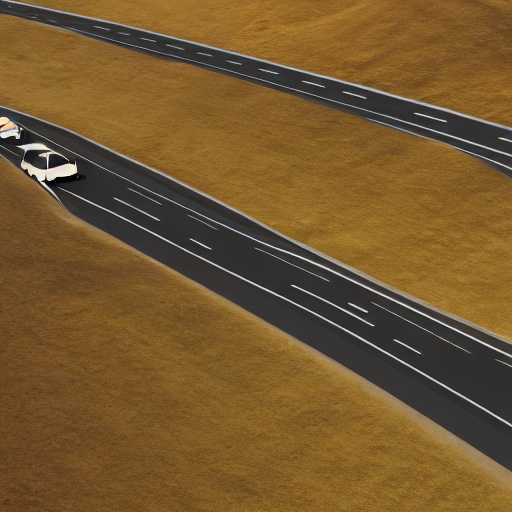

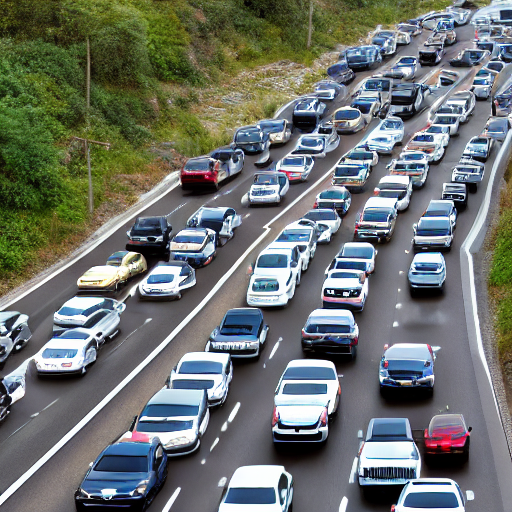

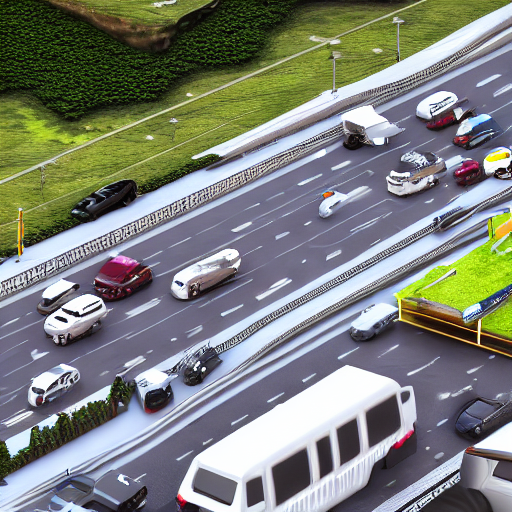

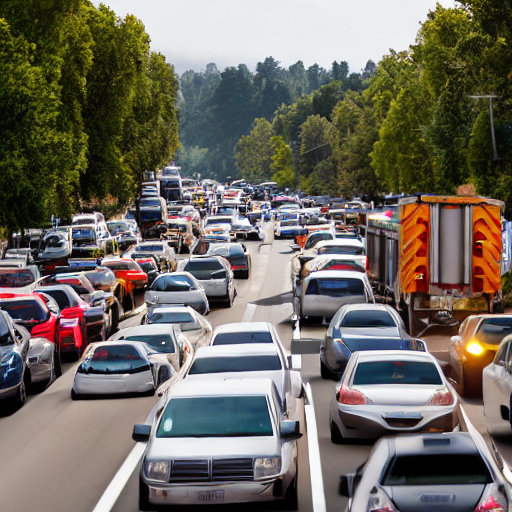

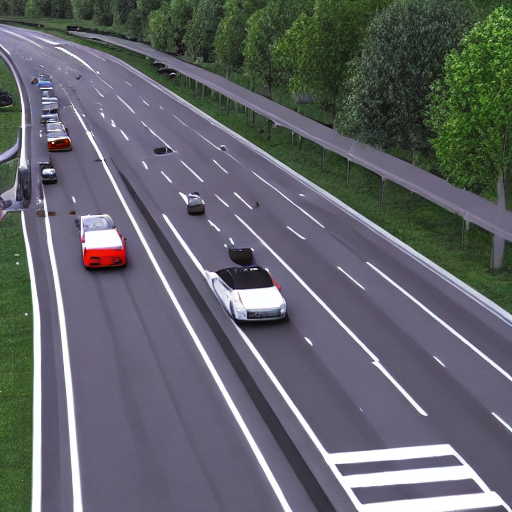

In [19]:
from IPython.display import display

for img in images:
    display(img)